In [21]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

# Configure figure size
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3)

def load_data(dataset_path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load data from a CSV file.

    Parameters:
    dataset_path (str): The path to the CSV file.

    Returns:
    tuple: A tuple containing the features (x) and the labels (y).
    """
    raw_df = pd.read_csv(dataset_path)
    x, y = raw_df.iloc[:, 1:-1], raw_df.iloc[:, -1]
    y = np.logical_not(preprocessing.LabelEncoder().fit(y).transform(y)).astype(int)
    return x, y


DATASET = "PathDIP"

x, y = load_data(f"../Data/{DATASET}.csv")

# Filter all features in x which appear less than 5 times (binary so can use sum)
x = x.loc[:, (x.sum(axis=0) >= 5)]

# Select a random 90% of the data
# idx = np.random.choice(x.shape[0], int(0.9 * x.shape[0]), replace=False)
# x = x.iloc[idx]
# y = y[idx]

x = x.to_numpy()

In [3]:
# Train a CatBoost model on the data
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [10]:
# Shuffle the data
idx = np.random.permutation(x.shape[0])
x = x[idx]
y = y[idx]

model = BalancedRandomForestClassifier(
            n_jobs=4,
            sampling_strategy=1.0,
            replacement=True,
            n_estimators=500,
            bootstrap=True
        )
model.fit(x, y)

# See the feature importances
importances = model.feature_importances_


n_features = 250

# Select the top n_features features
x = x[:, np.argsort(importances)[::-1][:n_features]]

In [20]:
# Use relief to select the top n_features features
n_features = 250

from skrebate import ReliefF
fs = ReliefF(n_features_to_select=n_features, n_neighbors=11, n_jobs=8)
x = fs.fit_transform(x, y)

In [4]:
# Use correlation to select the top n_features features

# Calculate the correlation matrix

feat_and_label = np.hstack((x, y.reshape(-1, 1)))


correlation_matrix = np.corrcoef(feat_and_label.T)[-1, :-1]

assert correlation_matrix.shape[0] == x.shape[1]

n_features = 500



x = x[:, np.argsort(np.abs(correlation_matrix))[::-1][:n_features]]



In [13]:
from sklearn.metrics import pairwise_distances

jaccard_distances = pairwise_distances(x, metric='jaccard')


c:\Users\Komi\Documents\GitHub\DR_Gene_Prediction_XofN_PUL\venv310\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [6]:
U = x[np.where(y == 0)]

U_row = np.expand_dims(U.sum(axis=1), axis=1)
D_col = np.expand_dims(x.T.sum(axis=0), 0)

R = np.zeros((len(U), len(x)))

R += U_row 
R += D_col
# print(D_col)

R -= U @ x.T

print(R)


[[1. 1. 3. ... 1. 1. 1.]
 [1. 1. 3. ... 1. 1. 1.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [1. 1. 3. ... 0. 0. 0.]
 [1. 1. 3. ... 0. 0. 0.]
 [1. 1. 3. ... 0. 0. 0.]]


In [7]:
pos = np.where(y == 0)[0]
for i in range(len(U)):
    # R[i, :pos[i]+1] = np.NaN
    R[i, pos[i]] = np.NaN


15.0


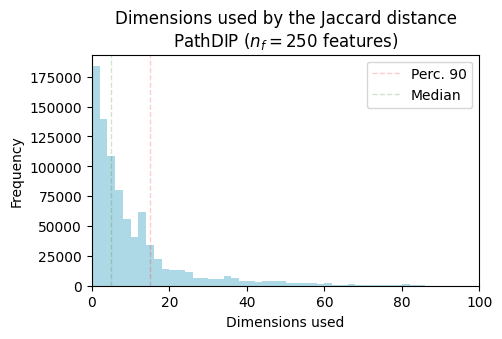

In [8]:
# Plot a histogram of the values in R
import matplotlib.pyplot as plt

plt.hist(R.flatten(), bins=[i for i in range(0,int(np.nanmax(R))+5) if i%2==0], color='lightblue')
p90 = np.nanpercentile(R, 80)
avg = np.nanmedian(R)
print(p90)
plt.axvline(p90, color='r', linestyle='dashed', linewidth=1, label='Perc. 90', alpha=0.2)
plt.axvline(avg, color='g', linestyle='dashed', linewidth=1, label='Median', alpha=0.2)
plt.xticks(np.arange(0, int(np.nanmax(R)), 20))
plt.xlim(0, min(np.nanmax(R),100))
plt.xlabel('Dimensions used')
plt.ylabel('Frequency')
plt.title(f'Dimensions used by the Jaccard distance\n{DATASET} ($n_f={n_features}$ features)')
plt.legend()
plt.show()

In [9]:
# Reduce the distances matrix to the top10 values per row
# Make the diaGOnal values NaN
jaccard_distances[np.diag_indices_from(jaccard_distances)] = np.NaN
jaccard_distances_u = jaccard_distances[np.where(y == 0)]
jaccard_top10_closest = np.zeros((jaccard_distances_u.shape[0], 10))
jaccard_top10_percent = np.zeros(jaccard_distances_u.shape[0])
jaccard_closest_is_unlabelled = np.zeros(jaccard_distances_u.shape[0])
for i in range(len(U)):
    top10 = np.argsort(jaccard_distances_u[i])[:10]
    
    jaccard_closest_is_unlabelled[i] = y[top10[0]] == 0
    # Count how many of those top10 correspond to an unlabeled sample
    jaccard_top10_percent[i] = np.sum(y[top10] == 0) / 10
    jaccard_top10_closest[i] = jaccard_distances_u[i, top10]

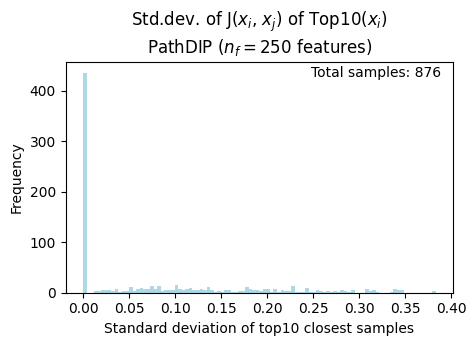

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.71428571 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571
 0.71428571 0.71428571 0.71428571 0.71428571]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1

In [10]:
# Plot a histogram of the standard deviations of the top10 values per row
stds = np.nanstd(jaccard_top10_closest, axis=1) 
plt.hist(stds, bins=100, color='lightblue')
plt.xlabel('Standard deviation of top10 closest samples')
plt.ylabel('Frequency')
plt.title(f'Std.dev. of J($x_i$, $x_j$) of Top10($x_i$)\n{DATASET} ($n_f={n_features}$ features)')
# Write in top right corner the total number of samples
plt.text(.8, .95, f'Total samples: {len(U)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()



# Print the top10 of all the rows with std 0
stds_0 = np.where(stds == 0)[0]
for i in stds_0:
    print(jaccard_distances[i][np.argsort(jaccard_distances_u[i])[:10]])

[0.8 0.7 0.3 1.  1.  1.  1.  0.8 1.  1.  1.  1.  1.  0.9 1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  0.9 1.  0.6 0.9 1.  1.  0.9 1.  1.  1.  1.  1.
 0.7 1.  1.  0.6 0.7 0.5 1.  0.9 0.8 0.8 1.  1.  1.  1.  0.6 1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  0.7 1.  0.9 1.  1.  1.  1.  1.  0.5 1.
 1.  1.  1.  1.  1.  1.  0.4 0.4 1.  1.  0.7 0.7 0.6 0.7 0.7 0.8 0.6 1.
 0.6 1.  1.  1.  1.  1.  1.  0.6 1.  1.  1.  1.  0.6 0.7 0.6 0.7 0.6 0.6
 0.6 1.  1.  1.  1.  0.8 0.8 0.9 1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.
 1.  1.  1.  1.  0.6 0.6 0.6 0.6 1.  1.  1.  0.9 1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.9 0.9 1.  1.  0.9 1.  1.  1.  1.  0.9 1.
 1.  1.  0.9 1.  1.  1.  0.9 0.9 1.  0.9 0.9 0.9 1.  0.6 0.8 1.  0.8 1.
 0.8 1.  0.5 1.  0.9 0.8 0.9 0.6 1.  1.  1.  0.8 1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.5 0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.9
 1.  1.  0.8 1.  1.  1.  0.9 0.9 1.  1.  1.  1.  1.  1.  0.9 1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 1.  1.  1.  1.  1.  1

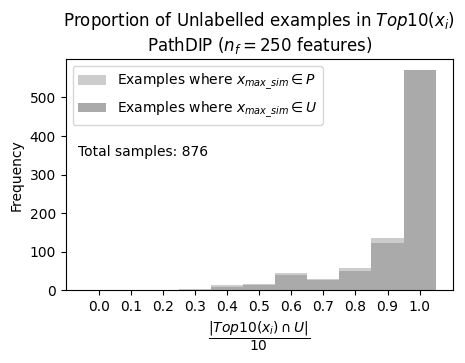

In [11]:
# Plot a histogram of the percentage of top10 closest samples that are unlabeled
print(jaccard_top10_percent)
plt.hist(jaccard_top10_percent, bins=[(i-1)/10+1/(10*2) for i in range(12)], color='#CCCCCC', label='Examples where $x_{max\_sim} \in P$', alpha=1)
plt.hist(jaccard_top10_percent[jaccard_closest_is_unlabelled == 1], bins=[(i-1)/10+1/(10*2) for i in range(12)], color='#AAAAAA', alpha=1, label = "Examples where $x_{max\_sim} \in U$")
plt.xlabel('$\dfrac{|Top10(x_i) \cap U|}{10}$')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Frequency')
plt.title(f'Proportion of Unlabelled examples in $Top10(x_i)$\n{DATASET} ($n_f={n_features}$ features)')
plt.text(.20, .6, f'Total samples: {len(U)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()